In [1]:
import pickle
from google.colab import drive
import re
from nltk.tokenize import RegexpTokenizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from itertools import islice
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import os

from operator import itemgetter
import matplotlib.pyplot as plt
import pandas as pd

from keras.preprocessing.image import load_img
from IPython.display import Image, display
import math
from textwrap import wrap

import numpy as np
from keras.applications.vgg16 import VGG16
from keras.utils.vis_utils import plot_model
from keras.models import Model





[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
dataset_zip_path = '/content/gdrive/MyDrive/Image_captioning_Dataset.zip'
pickle_path = '/content/gdrive/MyDrive/set_3.pkl'
dataset_path = os.path.join(os.path.dirname(dataset_zip_path), 'Flicker8k_Dataset')

In [4]:
# extract the dataset
if not os.path.exists(dataset_path):
  with zipfile.ZipFile(dataset_path,"r") as zip_ref:
      zip_ref.extractall(os.path.dirname(dataset_zip_path))
else:
  print("dataset extracted already!")

dataset extracted already!


In [5]:
# read the pickle dataset
objects = []
with open(pickle_path, "rb") as openfile:
    while True:
        try:
            objects.append(pickle.load(openfile))
        except EOFError:
            break
print(len(objects))
objects[0][:10]

1


['3033668641_5905f73990.jpg#0\tA man in a white helmet cling to a sheer rock face',
 '2608289957_044849f73e.jpg#0\tA baby sit on a tire and hold a toy .',
 '2723477522_d89f5ac62b.jpg#4\ttwo dog play in the grass .',
 '3453019315_cfd5c10dae.jpg#2\tA man do a bike trick on a dirt path .',
 '3524975665_7bec41578b.jpg#1\tA woman in a yellow jacket and brown hat stand on a path by a lake .',
 '3461041826_0e24cdf597.jpg#2\tA black and white dog be splash in a stream .',
 '414568315_5adcfc23c0.jpg#4\tA child be use chopstick on overturned kitchen item .',
 '2657484284_daa07a3a1b.jpg#0\tA kayak on a river be pass by a wire bridge that join both bank .',
 '2860667542_95abec3380.jpg#2\tA white water bird take flight from a lake .',
 '2222498879_9e82a100ab.jpg#3\tA tan and black dog walk happy through a field .']

In [6]:
# convert to required format, remove punctuations, lowercase the captions.

captions_dict = defaultdict(list)
tokenizer = RegexpTokenizer(r'\w+')

# create a word count dictionary.
word_count = defaultdict(lambda: 0)
for record in objects[0]:
  (name, caption_num, caption) = re.split(r'#|\t', record, maxsplit=2)
  # remove stopwords, convert to lowercase, remove punctuations.
  caption_words = tokenizer.tokenize(caption.lower())
  for word in caption_words:
    word_count[word] += 1
  captions_dict[name].append(' '.join(caption_words))

dict(islice(captions_dict.items(), 5))


{'2608289957_044849f73e.jpg': ['a baby sit on a tire and hold a toy',
  'boy in pajama with red and yellow toy seat on tire near plant',
  'a little kid with a red toy be sit on a tire',
  'child hold plastic car sit on a tire'],
 '2723477522_d89f5ac62b.jpg': ['two dog play in the grass',
  'a large brown dog be chase after a little brown dog',
  'a big dog chase a little dog on the grass',
  'two brown dog run through the grass together'],
 '3033668641_5905f73990.jpg': ['a man in a white helmet cling to a sheer rock face',
  'a man with all his equipment rock climb',
  'a rock climber wear a white helmet'],
 '3453019315_cfd5c10dae.jpg': ['a man do a bike trick on a dirt path',
  'man perform a trick on a bicycle outside',
  'a helmeted male airborne on a bike on a dirt road'],
 '3524975665_7bec41578b.jpg': ['a woman in a yellow jacket and brown hat stand on a path by a lake',
  'a young woman wait under a sculpture in a park',
  'a woman in a yellow coat be stand on a sidewalk']}

In [7]:
# create a vocabulary of the words that occur more than a specific threashold.
threshold = 5

vocabulary = set()

for word, count in word_count.items():
  if count >= threshold:
    vocabulary.add(word)

# total vocab size
print(len(vocabulary))

# sort the word count dict by values.
word_count = dict(sorted(word_count.items(), key = itemgetter(1), reverse = True))

1821


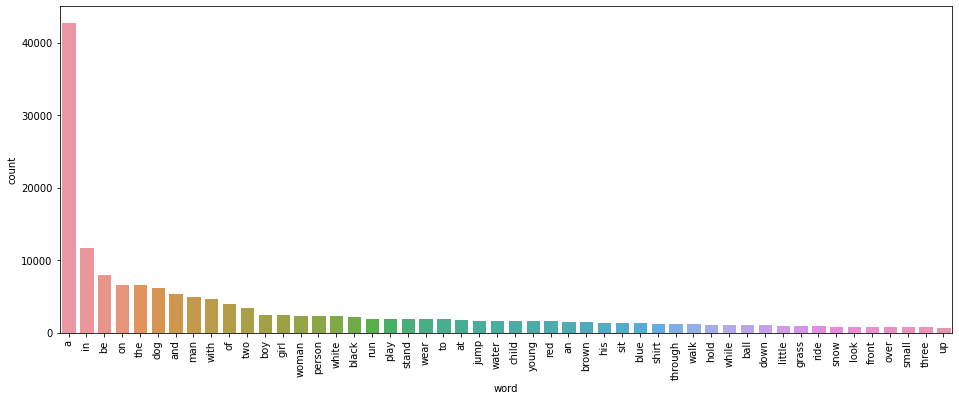

In [8]:
# plot top 50 words from word_count dict.
plt.figure(figsize=(16,6))
plt.xticks(rotation='vertical')

df = pd.DataFrame(word_count.items(), columns=['word', 'count'])
sns.set(style="whitegrid")
sns.barplot(x='word', y='count', data=df[:50])

count    25000.000000
mean        10.774480
std          3.773119
min          1.000000
25%          8.000000
50%         10.000000
75%         13.000000
max         33.000000
Name: caption_size, dtype: float64

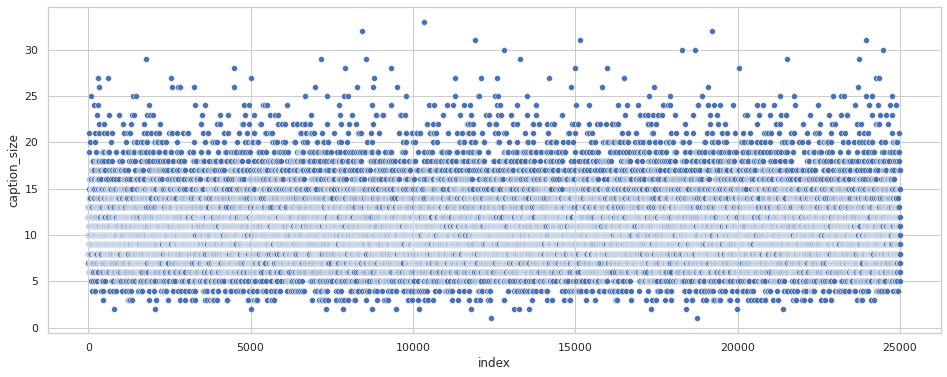

In [9]:
# caption words (min, max, avg.)

caption_sizes = {}
i=0
for captions in captions_dict.values():
  for caption in captions:
    caption_sizes[i] = len(str.split(caption, ' '))
    i += 1

df1 = pd.DataFrame(caption_sizes.items(), columns=['index', 'caption_size'])

plt.figure(figsize=(16,6))

sns.set(style="whitegrid")
sns.scatterplot(x='index', y='caption_size', data=df1)
df1['caption_size'].describe()

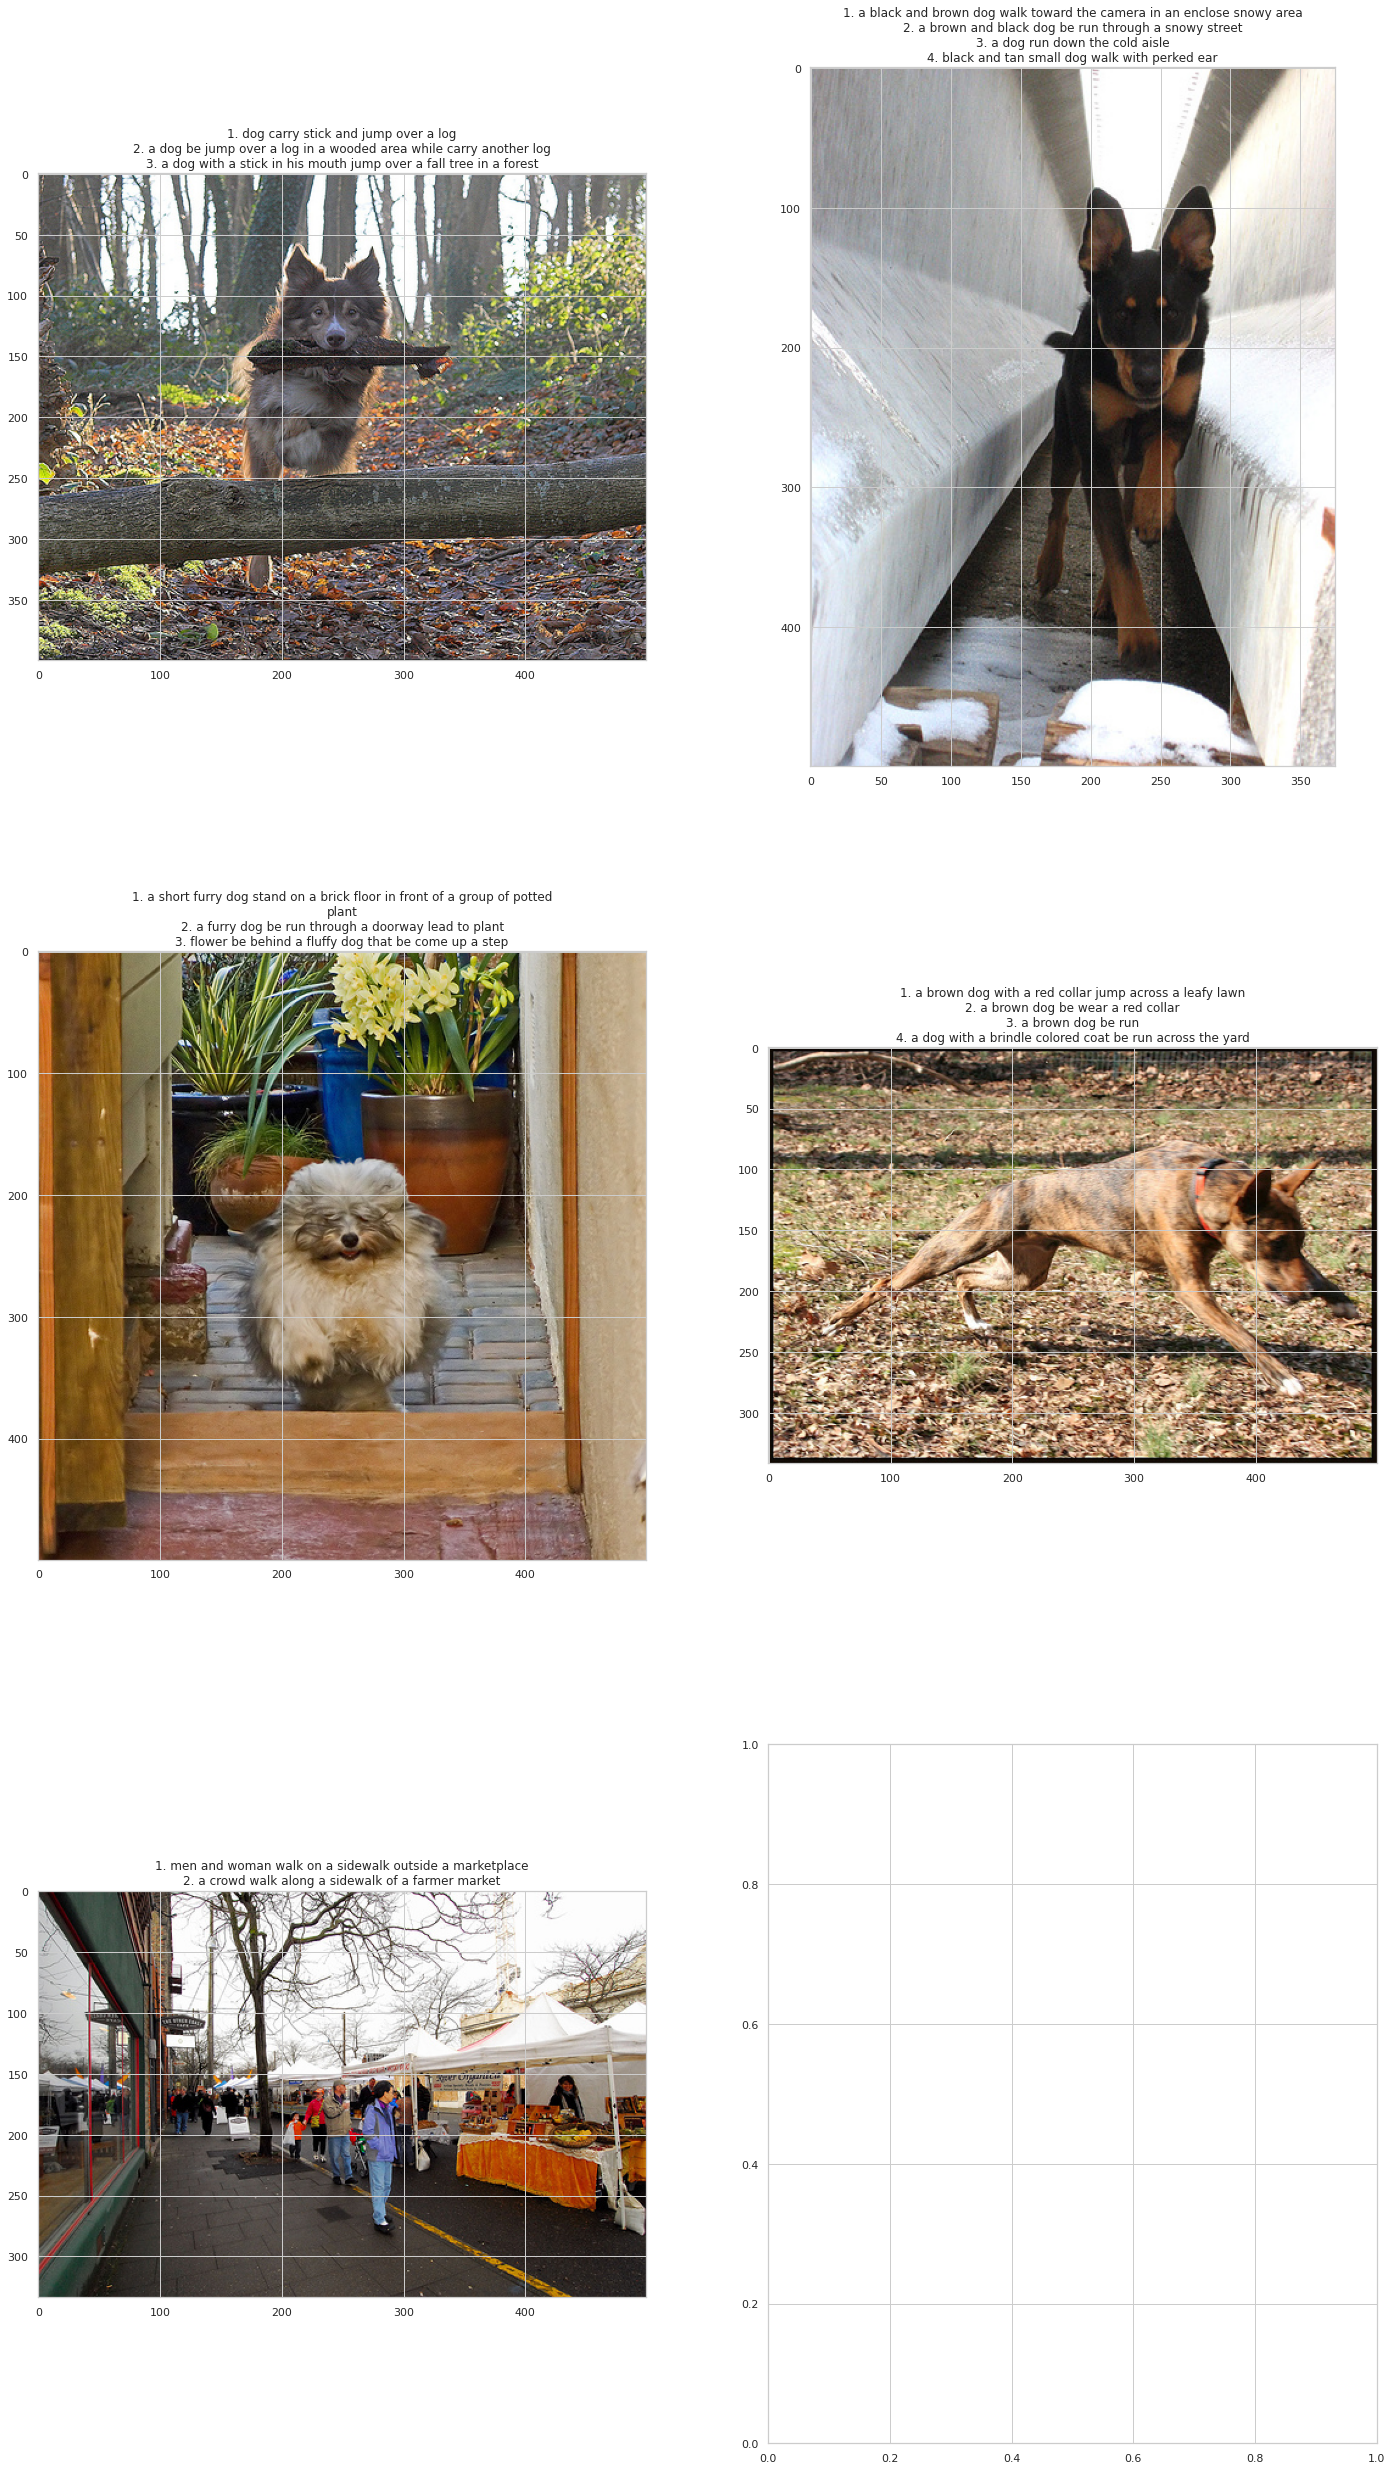

In [10]:
# print N samples and their captions.

N = 5       # total images
ncols = 2   #number of columns in the grid

# create a grid.
fig, axes = plt.subplots(nrows=math.ceil(N/ncols), ncols=ncols, figsize=(24,24), squeeze=False)

# adjust grid spacing to accomodate multiple captions.
fig.subplots_adjust(left=None, bottom=None, right=None, top=1.5, wspace=None, hspace=None)


count = 0
for root, dirs, files in os.walk(dataset_path):
  for file in files:
    (i, j) = (count // ncols, count % ncols)    # grid i, j coordinates
    image = load_img(os.path.join(dataset_path, file))
    axes[i, j].imshow(image)

    # number the title, wrap long titles (to default 70 char width)
    title = "\n".join(["{}. {}".format(i+1, "\n".join(wrap(v))) for i, v in enumerate(captions_dict[file])])
    axes[i, j].title.set_text(title)
    count += 1
    if count >= N:
      break



In [12]:
# split captions data in training/test sets

train_ratio = 0.9

image_names = [x for x in captions_dict.keys()]
np.random.shuffle(image_names)

train_size = int(len(image_names) * train_ratio)

train_data = dict({k: captions_dict[k] for k in image_names[:train_size]})
test_data = dict({k: captions_dict[k] for k in image_names[train_size:]})

len(train_data), len(test_data)

(7215, 802)

In [13]:

model = VGG16(weights='imagenet')
model.summary()

553476096/553467096 [==============================] - 16s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

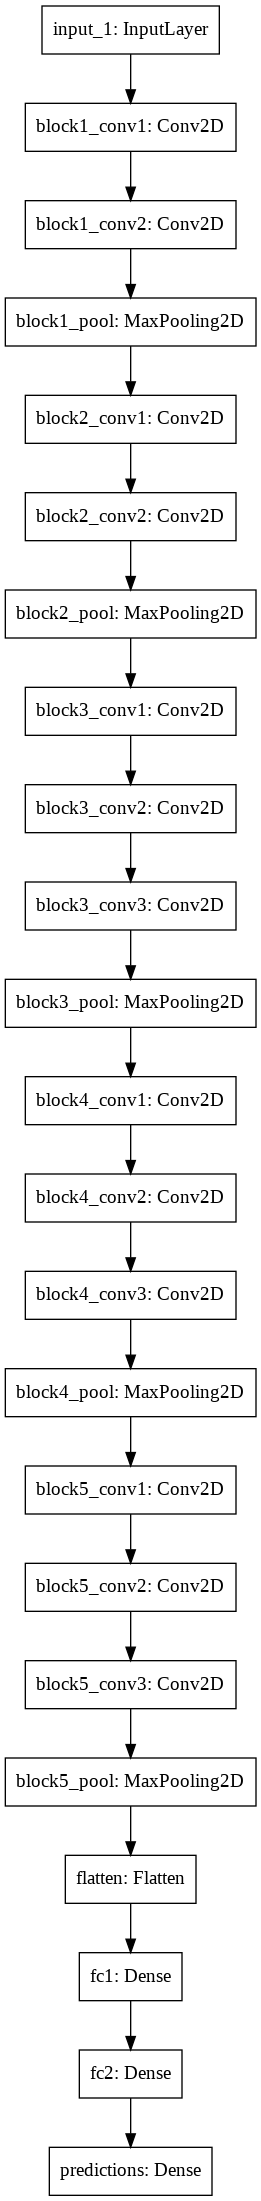

In [14]:
plot_model(model, to_file='vgg.png')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

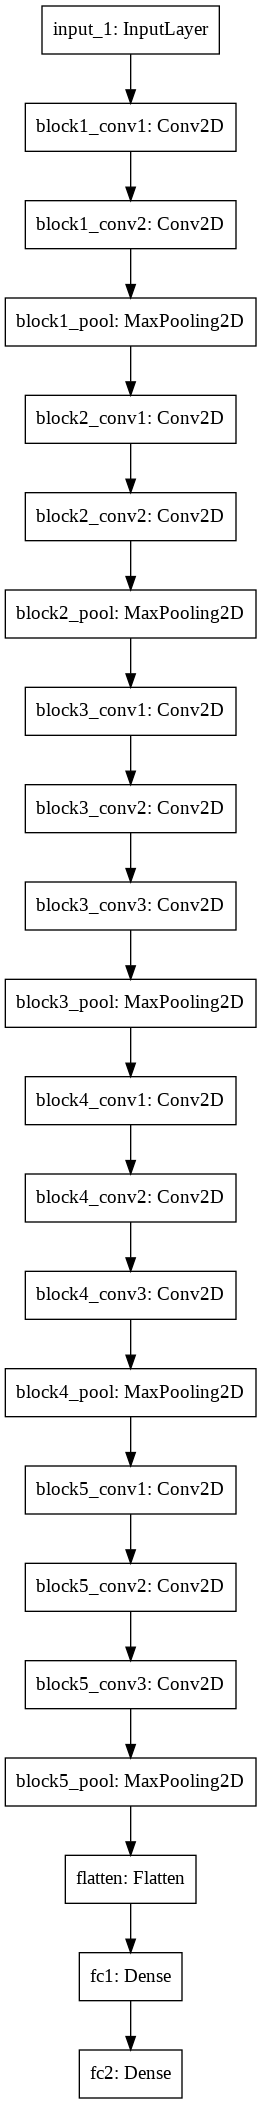

In [15]:
# recreate model removing last prediction layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
model.summary()
plot_model(model, to_file='vgg-1.png')

---

The model above takes images as **224 x 224 x 3** size.

---



In [16]:
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input

image_features = dict()
for filename in train_data:
    
  filepath = os.path.join(dataset_path, name)
  image = load_img(filepath, target_size=(224, 224))
    
  # reshape the image
  image = img_to_array(image)
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    
  # preprocess
  image = preprocess_input(image)
    
  # extract features
  image_features[filename] = model.predict(image, verbose=0)

# print 5 items
dict(islice(image_features.items(), 5))

{'1509786421_f03158adfc.jpg': array([[0.       , 0.       , 2.2321024, ..., 0.       , 0.       ,
         0.       ]], dtype=float32),
 '1679617928_a73c1769be.jpg': array([[0.       , 0.       , 2.2321024, ..., 0.       , 0.       ,
         0.       ]], dtype=float32),
 '2554531876_5d7f193992.jpg': array([[0.       , 0.       , 2.2321024, ..., 0.       , 0.       ,
         0.       ]], dtype=float32),
 '3427540832_c882fded1d.jpg': array([[0.       , 0.       , 2.2321024, ..., 0.       , 0.       ,
         0.       ]], dtype=float32),
 '3640443200_b8066f37f6.jpg': array([[0.       , 0.       , 2.2321024, ..., 0.       , 0.       ,
         0.       ]], dtype=float32)}

In [17]:
len(image_features)
from pickle import dump
dump(image_features, open('./image_features_training-set.pkl', 'wb'))



In [19]:
len(image_features)

7215

Now we take the test dataset images, and the corresponding captions and pass it to the model, one word initially then 2 then 3 and so on.

Also mark the start/end of the caption.

All the captions should be padded to have the same length.